<a href="https://colab.research.google.com/github/seanrjohnson/protein_scoring/blob/main/colab_notebooks/ESM_MSA_sequence_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Protein sequence generation using the ESM-MSA model

This notebook uses the ESM-MSA model (a transformer-based neural network trained on protein multiple sequence alignments) to generate new protein sequences by iteratively mutating sequences from an input alignment. It has two modes:

### Single-sequence sampling:
Masking and sampling is done on just a single sequence at a time, the “template sequence”. The rest of the MSA is filled out by using phmmer (from the Hmmer3 suite) to search the reference sequences using the template sequence as a query, and keeping the top hits, not including the self-hit of the template sequence, and an MSA of the set of hit sequences is generated using MAFFT.

This method is slow, because every round of sampling only generates one new sequence. Sequences generated by this method tend to be more similar to the starting sequences than sequences generated from Whole-MSA sampling.

### Whole-MSA sampling:
The templates should be an MSA. A subset of templates is randomly drawn in pre-aligned format from the template MSA. A random selection of amino acids from the entire MSA is masked and sampled in each iteration. The process is repeated with different random draws from the training MSA until the desired number of new sequences have been generated.

This method is fast, because every round of sampling generates a number of new sequences equal to the size of the MSA. Sequences generated by this method tend to be more divergent from the starting sequences than sequences generated from single-sequence sampling.

## Setup

In [1]:
%%capture cap --no-stderr

#@title 1. Install dependencies and set up directories

from glob import glob
import subprocess
from pathlib import Path
from google.colab import files

# create data directory
!rm -r sample_data

!mkdir templates references


# for conda, see: https://github.com/ambuvjyn/Codes-for-Medium-Articles/blob/main/Google_Colab_Conda/conda_colabs.ipynb

!apt-get -qq update > /dev/null
!apt-get -qq install  hmmer mafft > /dev/null
#install esm
!pip install -q git+https://github.com/facebookresearch/esm.git@e5e7b06b9a093706607c229ab1c5c9821806814d > /dev/null

# install protein_gibbs_sampler
!git clone https://github.com/seanrjohnson/protein_gibbs_sampler
!cd protein_gibbs_sampler ; git checkout 5f91ae56e7e8be409d225b337d230095f63d9e44 ; yes | pip install -q --no-dependencies . > /dev/null
!yes | pip install -q biopython~=1.79 pytest-datadir~=1.4.1 > /dev/null

# install mafft
# maybe try from the .deb instead? or from apt-get
# !wget https://mafft.cbrc.jp/alignment/software/mafft-7.487-without-extensions-src.tgz
# !tar xf mafft-7.487-without-extensions-src.tgz
# !cd mafft-7.487-without-extensions/core ; make clean; make >/dev/null; make install >/dev/null
# !rm -r mafft

# install hmmer
# maybe try from the .deb instead?
# !wget http://eddylab.org/software/hmmer/hmmer-3.3.2.tar.gz
# !tar xf hmmer-3.3.2.tar.gz
# !cd hmmer-3.3.2; ./configure; make >/dev/null; make install
# !rm -r hmmer*


# Load model weights
ESM_MSA_INIT_TMP_FILE="/tmp/ESM_MSA_INIT_TMP_FILE.fasta"
with open(ESM_MSA_INIT_TMP_FILE, "w") as f:
  f.write(""">1
M
>2
M""")

subprocess.run(['python', "protein_gibbs_sampler/src/pgen/likelihood_esm_msa.py", "-i", ESM_MSA_INIT_TMP_FILE, "-o", "/dev/null", "--reference_msa", ESM_MSA_INIT_TMP_FILE, "--subset_strategy", "in_order", "--alignment_size", "1", "--count_gaps", "--mask_distance", "6", "--device", "cpu"])

# Import parse_fasta and set paths to outptu files.
from pgen.utils import parse_fasta
single_sequence_sampling_outfile = '/tmp/single_sequence.fasta'
whole_MSA_sampling_outfile = '/tmp/whole_MSA.fasta'



#### 2. Use the Colab UI to upload reference sequences.

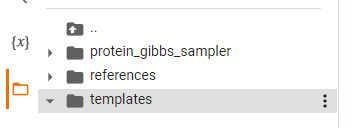


## Run sampling

In [2]:
#@title Run single-sequence sampling (defaults reflect settings for round 2 of the enzyme metrics paper)

#@markdown The `templates` directory should contain fasta files of sequences you want to resample. The `references` directory should contain reference sequences from the same family. The top `MSA_size - 1` pHMMER hits for each template sequence will be found in the reference sequences. Templates and references should be gapless. If they are aligned, the gaps will be ignored and they will be re-aligned with each template.

#@markdown Warning: The number of new sequences generated will be `generated_sequences_per_template` times the number of sequences in your `templates` folder. If you have a lot of template sequences, this could result in long run times.

#@markdown ___

#@markdown If set, then ignore the `references` directory, and use the fasta files in the `templates` directory as both templates and references.
use_templates_as_references = True #@param ["True", "False"] {type:"raw"}

#@markdown number of resamplings to run for each template sequence (total number of output sequences will be this times the number of template sequences).
generated_sequences_per_template = 3 #@param {type:"integer"}
assert generated_sequences_per_template >= 0

#@markdown How many sequences to use in the MSA (including the template sequence).
MSA_size = 32 #@param {type:"integer"}
assert MSA_size >= 1

#@markdown Divide each pass into this many steps. In each pass, every amino acid is masked once. The fraction of positions randomly masked at each step is: `1/steps_per_pass`
steps_per_pass = 10 #@param {type:"number"}
assert steps_per_pass >= 1

#@markdown how many rounds of burn-in sampling to run, where amino acids are drawn from the full probability distribution.
burn_in_passes = 2 #@param {type:"integer"}
assert burn_in_passes >= 0

#@markdown how many rounds of top-k sampling to run, where amino acids are drawn from only the top-k most-likely amino acids at each masked position.
top_k_passes = 1 #@param {type:"integer"}
assert top_k_passes >= 0

#@markdown k to use for top-k sampling rounds. (if 0 or >=20 then top_k passes are equivalent to burn-in passes)
k = 1 #@param {type:"integer"}
assert k >= 0

#@markdown If keep_identical is True, then reference sequences identical to the template sequence will allowed in the MSA (which is probably not what you want).
keep_identical = False #@param ["False", "True"] {type:"raw"}

#@markdown Use the original implementation's behavior of sampling from the last sequence in the MSA rather than the first.
legacy = False #@param ["True", "False"] {type:"raw"}

#@markdown Don't resample positions where more than this percent of sequences in the alignment contain gaps.
gap_percent_threshold = 80 #@param {type:"integer"}
assert gap_percent_threshold >= 0


passes = burn_in_passes + top_k_passes
assert passes >= 1



#concatenate reference sequences
template_seqs_file = "/tmp/template_seqs.fasta"
with open(template_seqs_file,"w") as fh:
  for target_fasta in glob("/content/templates/*"):
    for name, seq in zip(*parse_fasta(target_fasta, return_names=True, clean="unalign")):
      print(f">{name}\n{seq}", file=fh)

if not use_templates_as_references:
  reference_seqs_file = "/tmp/reference_seqs.fasta"
  with open(reference_seqs_file,"w") as fh:
    for reference_fasta in glob("/content/references/*"):
      for name, seq in zip(*parse_fasta(reference_fasta, return_names=True, clean="unalign")):
        print(f">{name}\n{seq}", file=fh)
else:
  reference_seqs_file = template_seqs_file


## Execute program
params = ['python', "protein_gibbs_sampler/src/pgen/pgen_msa_revised.py",
          '--templates', template_seqs_file,
          '--references', reference_seqs_file,
          '--seqs_per_template', str(generated_sequences_per_template),
          '--steps', str(steps_per_pass),
          '--passes', str(passes),
          '--burn_in', str(burn_in_passes),
          '--top_k', str(k),
          '--device', 'gpu',
          '--alignment_size', str(MSA_size),
          '-o', single_sequence_sampling_outfile,
          '--gap_percent_threshold', str(gap_percent_threshold)
          ]
if keep_identical:
  params.append('--keep_identical')

if legacy:
  params.append('--legacy')

proc = subprocess.run(params, check=True)
# print(proc.stdout)
# print(proc.stderr)

if Path(single_sequence_sampling_outfile).is_file():
 files.download(single_sequence_sampling_outfile)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Run whole-MSA sampling (defaults reflect settings for round 1 of the enzyme metrics paper)

#@markdown The `templates` directory should contain a fasta file of an MSA of the sequences you want to resample. Subsets of this MSA will be drawn for sampling. The `references` directory will be ignored. If `templates` contains more than one file (not recommended), all sequences in all files should all be the the same length (including gaps), because sequences for sampling will be drawn from all of them, and not realigned.

#@markdown ___

#@markdown Number of new sequences to generate. New sub-MSAs will be drawn and resampled until this many sequences have been generated.
seqs_to_generate = 64 #@param {type:"integer"}
assert seqs_to_generate >= 1

#@markdown How many sequences to use in the MSA. This many sequences will be randomly drawn from the template MSA every round.
MSA_size = 64 #@param {type:"integer"}
assert MSA_size >= 1

#@markdown If `delete_insertions` is `True`, then remove all lowercase and `.` characters from input sequences. Default: convert lower to upper and `.` to `-`. This option can be useful if your input files are in A3M format (which is not recommended).
delete_insertions = False #@param ["False", "True"] {type:"raw"}

#@markdown Percent of positions in the MSA to be randomly selected for masking each iteration.
positions_percent_to_mask_per_iter = 10 #@param {type:"number"}
assert positions_percent_to_mask_per_iter >= 0

#@markdown Number of burn-in iters to run each round.
burn_in_iters = 20 #@param {type:"number"}
assert burn_in_iters >= 0

#@markdown Number of top-k iters to run each round.
top_k_iters = 0 #@param {type:"integer"}
assert top_k_iters >= 0

#@markdown k to use for top-k sampling iters. (if 0 or >=20 then top_k passes are equivalent to burn-in passes)
k = 0 #@param {type:"integer"}
assert k >= 0

#@markdown By default the output from this method retains gaps, such that it aligns with the input MSA. Checking this box will unalign the output before downloading.
unalign_output = False #@param {type:"boolean"}

num_iters = burn_in_iters + top_k_iters
assert num_iters >= 1


#concatenate reference sequences
template_seqs_file = "/tmp/template_seqs.fasta"
with open(template_seqs_file,"w") as fh:
  for target_fasta in glob("/content/templates/*"):
    for name, seq in zip(*parse_fasta(target_fasta, return_names=True, clean=None)):
      print(f">{name}\n{seq}", file=fh)

params_file = "/tmp/whole_MSA_sampling_params.tsv"
with open(params_file, "w") as fh:
  print(
      "whole_MSA\t{" + f"'top_k': {k}, 'num_iters': {num_iters}, 'burnin': {burn_in_iters}, 'num_positions_percent': {positions_percent_to_mask_per_iter}, 'mask': True ,'in_order':False"  + "}" + f"\t{template_seqs_file}",
      file=fh
  )

## Execute program
params = ['python', "protein_gibbs_sampler/src/pgen/pgen_msa.py",
          '-i', params_file,
          '--num_output_sequences', str(seqs_to_generate),
          '--device', 'gpu',
          '--subset_strategy', 'random',
          '--alignment_size', str(MSA_size),
          '-o', '/tmp'
          ]
if delete_insertions:
  params.append('--delete_insertions')
proc = subprocess.run(params, check=True)
# print(proc.stdout)
# print(proc.stderr)

if unalign_output:
  tmp_whole_MSA_sampling_file = "/tmp/tmp_whole_MSA_sampling_file.fasta"
  with open(tmp_whole_MSA_sampling_file,"w") as fh:
      for name, seq in zip(*parse_fasta(whole_MSA_sampling_outfile, return_names=True, clean="unalign")):
        print(f">{name}\n{seq}", file=fh)
  Path(tmp_whole_MSA_sampling_file).rename(whole_MSA_sampling_outfile)

if Path(whole_MSA_sampling_outfile).is_file():
  files.download(whole_MSA_sampling_outfile)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Download result
if Path(single_sequence_sampling_outfile).is_file():
 files.download(single_sequence_sampling_outfile)

if Path(whole_MSA_sampling_outfile).is_file():
  files.download(whole_MSA_sampling_outfile)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# References

### Metrics manuscript
TBA

### ESM-MSA
Rao, Roshan M., Jason Liu, Robert Verkuil, Joshua Meier, John Canny, Pieter Abbeel, Tom Sercu, and Alexander Rives. “MSA Transformer.” BioRxiv, February 13, 2021, 2021.02.12.430858. https://doi.org/10.1101/2021.02.12.430858.

# Troubleshooting


This notebook expects to be run on a GPU instance:
`Runtime --> change runtime type --> GPU`

Depending on what kind of GPU you get, you may be limited in the sequence size and MSA size that you can use. We tested the notebook on Malate Dehydrogenase proteins (MSA size 380 amino acids aa) with MSAs up to 64 sequences on a Tesla T4 GPU (16 Gb).

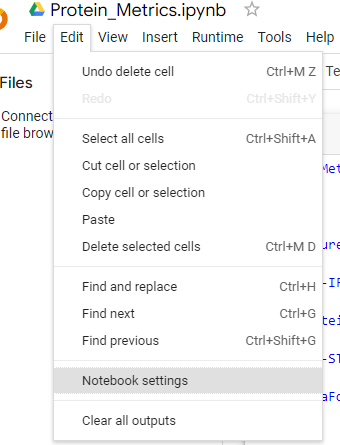

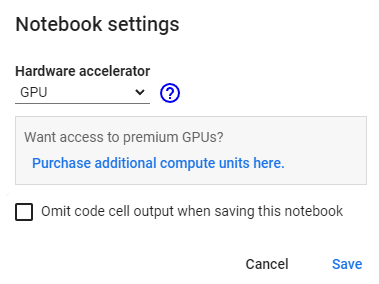
